### TD($\lambda$) prediction algorithm 

In [40]:
from typing import Sequence, Iterable, Iterator, TypeVar, List, Sequence, Mapping, Callable, Dict, Tuple
from rl.function_approx import Gradient, AdamGradient, LinearFunctionApprox
from rl.distribution import Categorical, Choose
from rl.iterate import converge, converged, last
import rl.markov_process as mp
from rl.markov_process import FiniteMarkovRewardProcess
from rl.markov_decision_process import NonTerminal
from rl.approximate_dynamic_programming import ValueFunctionApprox
from rl.approximate_dynamic_programming import extended_vf

from rl.chapter2.simple_inventory_mrp import SimpleInventoryMRPFinite, InventoryState
from rl.chapter2.simple_inventory_mrp import InventoryState
from rl.chapter10.prediction_utils import (
    mc_prediction_learning_rate,
    td_prediction_learning_rate,
    td_lambda_prediction_learning_rate
)

import numpy as np
import itertools
from itertools import islice

import pprint
import matplotlib.pyplot as plt

S = TypeVar('S')

#### Tabular Case

In [2]:
def td_lambda_prediction_tab(
        traces: Iterable[Iterable[mp.TransitionStep[S]]],
        gamma: float,
        lambd: float,
        alpha: float
) -> Iterator[Mapping[S, float]]:
    
    vf: Mapping[S, float] = dict() # State VF approximation

    yield vf
    for trace in traces:
        el_tr: Mapping[S, float] = dict() # Eligibility trace

        trace_seq: Sequence[mp.TransitionStep[S]] = list(trace)
        for t, step in enumerate(trace_seq):
            x: NonTerminal[S] = step.state
            el_tr[x.state] = lambd * gamma * el_tr.get(x.state, 0) + 1
            y: float = step.reward + gamma * vf.get(step.next_state.state, 0) - vf.get(x.state, 0)
            for state in vf.keys():
                vf[state] = vf.get(state, 0) + alpha * y * el_tr.get(state, 0)

            yield vf

#### Function Approximation Case

In [ ]:

def td_lambda_prediction_func_approx(
        traces: Iterable[Iterable[mp.TransitionStep[S]]],
        approx_0: ValueFunctionApprox[S],
        γ: float,
        lambd: float
) -> Iterator[ValueFunctionApprox[S]]:
    func_approx: ValueFunctionApprox[S] = approx_0
    yield func_approx

    for trace in traces:
        el_tr: Gradient[ValueFunctionApprox[S]] = Gradient(func_approx).zero()
        for step in trace:
            x: NonTerminal[S] = step.state
            y: float = step.reward + γ * \
                extended_vf(func_approx, step.next_state)
            el_tr = el_tr * (γ * lambd) + func_approx.objective_gradient(
                xy_vals_seq=[(x, y)],
                obj_deriv_out_fun=lambda x1, y1: np.ones(len(x1))
            )
            func_approx = func_approx.update_with_gradient(
                el_tr * (func_approx(x) - y)
            )
            yield func_approx

#### Previous Implmentation of VF by Policy Evaluation
Simple MRP Inventory Func Approx example

In [33]:
capacity: int = 2
poisson_lambda: float = 1.0
holding_cost: float = 1.0
stockout_cost: float = 10.0

gamma: float = 0.9
lambda_param: float = 0.5

si_mrp: SimpleInventoryMRPFinite = SimpleInventoryMRPFinite(
    capacity=capacity,
    poisson_lambda=poisson_lambda,
    holding_cost=holding_cost,
    stockout_cost=stockout_cost
)
nt_states: Sequence[NonTerminal[InventoryState]] = si_mrp.non_terminal_states
true_vf: np.ndarray = si_mrp.get_value_function_vec(gamma=gamma)

mc_episode_length_tol: float = 1e-6
num_episodes = 10000

td_episode_length: int = 100
initial_learning_rate: float = 0.03
half_life: float = 1000.0
exponent: float = 0.5

ffs: Sequence[Callable[[NonTerminal[InventoryState]], float]] = \
    [(lambda x, s=s: float(x.state == s.state)) for s in nt_states]

mc_ag: AdamGradient = AdamGradient(
    learning_rate=0.05,
    decay1=0.9,
    decay2=0.999
)

td_ag: AdamGradient = AdamGradient(
    learning_rate=0.003,
    decay1=0.9,
    decay2=0.999
)

mc_func_approx: LinearFunctionApprox[NonTerminal[InventoryState]] = \
    LinearFunctionApprox.create(
        feature_functions=ffs,
        adam_gradient=mc_ag
    )

td_func_approx: LinearFunctionApprox[NonTerminal[InventoryState]] = \
    LinearFunctionApprox.create(
        feature_functions=ffs,
        adam_gradient=td_ag
    )

it_mc: Iterable[ValueFunctionApprox[InventoryState]] = \
    mc_prediction_learning_rate(
        mrp=si_mrp,
        start_state_distribution=Choose(nt_states),
        gamma=gamma,
        episode_length_tolerance=mc_episode_length_tol,
        initial_func_approx=mc_func_approx
    )

it_td: Iterable[ValueFunctionApprox[InventoryState]] = \
    td_prediction_learning_rate(
        mrp=si_mrp,
        start_state_distribution=Choose(nt_states),
        gamma=gamma,
        episode_length=td_episode_length,
        initial_func_approx=td_func_approx
    )

it_td_lam: Iterable[ValueFunctionApprox[InventoryState]] = \
    td_lambda_prediction_learning_rate(
        mrp=si_mrp,
        start_state_distribution=Choose(nt_states),
        gamma=gamma,
        lambd=lambda_param,
        episode_length=td_episode_length,
        initial_func_approx=td_func_approx
    )

mc_episodes: int = 30000
mc_rmse_conv: List[float] = []
for i, mc_vf in enumerate(islice(it_mc, mc_episodes)):
    mc_rmse: float = np.sqrt(sum(
        (mc_vf(s) - true_vf[i]) ** 2 for i, s in enumerate(nt_states)
    ) / len(nt_states))
    mc_rmse_conv.append(mc_rmse)
    #print(f"MC: Iteration = {i:d}, RMSE = {mc_rmse:.3f}")

td_experiences: int = 30000
td_rmse_conv: List[float] = []
for i, td_vf in enumerate(islice(it_td, td_experiences)):
    td_rmse: float = np.sqrt(sum(
        (td_vf(s) - true_vf[i]) ** 2 for i, s in enumerate(nt_states)
    ) / len(nt_states))
    td_rmse_conv.append(td_rmse)
    #print(f"TD: Iteration = {i:d}, RMSE = {td_rmse:.3f}")

td_lambda_experiences: int = 30000
td_lambda_conv: List[float] = []
for i, td_lam_vf in enumerate(islice(it_td_lam, td_lambda_experiences)):
    td_lam_rmse: float = np.sqrt(sum(
        (td_lam_vf(s) - true_vf[i]) ** 2 for i, s in enumerate(nt_states)
    ) / len(nt_states))
    td_lambda_conv.append(td_lam_rmse)
    #print(f"TD: Iteration = {i:d}, RMSE = {td_rmse:.3f}")

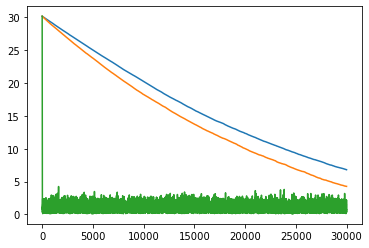

In [34]:
plt.plot(range(30000), td_rmse_conv, label="TD")
plt.plot(range(30000), td_lambda_conv, label="TD(lambda)")
plt.plot(range(30000), mc_rmse_conv, label="MC")

### Random Walk MRP

In [43]:
class RandomWalkMRP2D(FiniteMarkovRewardProcess[Tuple[int, int]]):
    barrier_1: int
    barrier_2: int
    p_up: float
    p_down: float

    def __init__(
        self,
        barrier_1: int,
        barrier_2: int,
        p_up: float,
        p_right: float
    ):
        self.barrier_1 = barrier_1
        self.barrier_2 = barrier_2
        self.p_up = p_up
        self.p_right = p_right
        super().__init__(self.get_transition_map())

    def get_transition_map(self) -> \
            Mapping[Tuple[int, int], Categorical[Tuple[Tuple[int, int], float]]]:
        states: List[Tuple[int, int]] = [(i, j) for i in range(1, self.barrier_1) for j in range(1, self.barrier_2)]
        d: Dict[Tuple[int, int], Categorical[Tuple[Tuple[int, int], float]]] = {
            (i, j) : Categorical({
                ((i + 1, j+1), 0. if (i < self.barrier_1 - 1) and (j < self.barrier_2 - 1) else 1.): self.p_up * self.p_right,
                ((i + 1, j-1), 0. if (i < self.barrier_1) else 1.): self.p_up * (1 - self.p_right),
                ((i - 1, j+1), 0. if (j < self.barrier_2) else 1.): (1 - self.p_up) * self.p_right,
                ((i - 1, j-1), 0.): (1 - self.p_up) * (1 - self.p_right),
            }) for i, j in states
        }
        return d

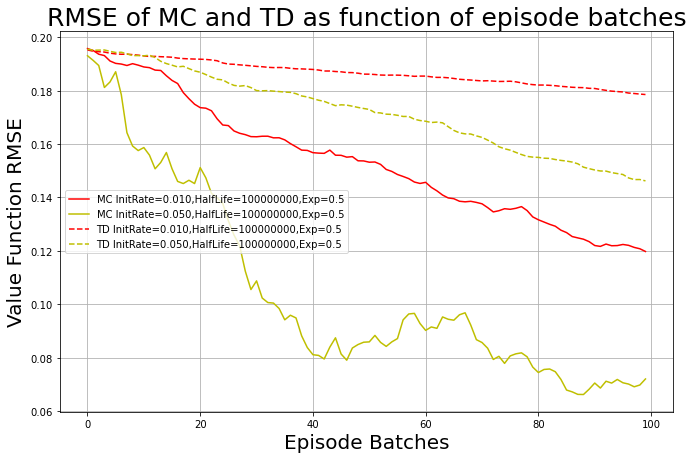

In [44]:
from rl.chapter10.prediction_utils import compare_td_and_mc

barrier_1: int = 10
barrier_2: int = 10
p_up: float = 0.8
p_right: float = 0.7
random_walk: RandomWalkMRP2D = RandomWalkMRP2D(
    barrier_1,
    barrier_2,
    p_up,
    p_right,
)
compare_td_and_mc(
    fmrp=random_walk,
    gamma=1.0,
    mc_episode_length_tol=1e-6,
    num_episodes=700,
    learning_rates=[(0.01, 1e8, 0.5), (0.05, 1e8, 0.5)],
    initial_vf_dict={s: 0.5 for s in random_walk.non_terminal_states},
    plot_batch=7,
    plot_start=0
)
